In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

class SkeletonDataset(Dataset):
    """
    Custom Dataset cho dữ liệu skeleton.
    Đọc dữ liệu từ file .npy và label từ file .pkl,
    sau đó định hình lại cho phù hợp với mô hình RNN/GRU.
    """
    def __init__(self, data_path, label_path):
        # Tải label
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)

        # Tải dữ liệu và chuyển sang tensor
        # Dữ liệu gốc có shape (N, C, T, V, M)
        raw_data = np.load(data_path)
        self.data = torch.from_numpy(raw_data).float()

        # Thông tin shape
        self.N, self.C, self.T, self.V, self.M = self.data.shape
        print(f"Loaded data from {data_path} with shape: ({self.N}, {self.C}, {self.T}, {self.V}, {self.M})")


    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Lấy dữ liệu và label tại index
        sample_data = self.data[index] # Shape: (C, T, V, M)
        label = self.labels[index]

        # Thay đổi shape để phù hợp với GRU
        # Chuyển (C, T, V, M) -> (T, C, V, M)
        sample_data = sample_data.permute(1, 0, 2, 3)

        # Làm phẳng các chiều C, V, M thành một vector đặc trưng duy nhất cho mỗi bước thời gian T
        # Shape sau khi làm phẳng: (T, C * V * M)
        # Ví dụ: (20, 3 * 61 * 1) = (20, 183)
        flattened_data = sample_data.reshape(self.T, -1)

        return flattened_data, torch.tensor(label, dtype=torch.long)

In [12]:
import random
def set_seed(seed_value):
    random.seed(seed_value) # Python's random module
    np.random.seed(seed_value) # NumPy
    torch.manual_seed(seed_value) # PyTorch on CPU
    torch.cuda.manual_seed_all(seed_value) # PyTorch on all GPUs (if available)
    
    # Cấu hình cho thuật toán cuDNN (thường được sử dụng bởi PyTorch trên GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Global seed set to {seed_value}")

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedGRUModel(nn.Module):
    """
    Mô hình GRU đa lớp phức tạp, tương đương với phiên bản Keras đã cho.
    """
    def __init__(self, input_size, num_classes):
        super(AdvancedGRUModel, self).__init__()

        # --- Lớp GRU ---
        # Keras: GRU(128, return_sequences=True, activation='relu')
        # PyTorch: nn.GRU không hỗ trợ trực tiếp activation='relu'. 
        # Chúng ta sẽ sử dụng nn.GRU tiêu chuẩn và thảo luận về điểm này bên dưới.
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0)

        self.gru2 = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(0)

        self.gru3 = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
        self.dropout3 = nn.Dropout(0)
        
        self.gru4 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.dropout4 = nn.Dropout(0)

        # Lớp GRU cuối cùng, tương đương return_sequences=False
        self.gru5 = nn.GRU(input_size=512, hidden_size=512, batch_first=True)

        # --- Khối Classifier (MLP) ---
        # Sử dụng nn.Sequential để nhóm các lớp Dense lại cho gọn gàng
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),       # Tương đương BatchNormalization() sau GRU
            nn.Linear(512, 512),
            nn.ReLU(),                 # Tương đương activation='relu'
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes) # Lớp output, không có softmax (xem giải thích)
        )

    def forward(self, x):
        # Luồng dữ liệu qua các lớp GRU
        # self.gru(x) trả về (output, h_n)
        # output có shape (batch, seq_len, hidden_size)
        # h_n là hidden state cuối cùng
        
        # return_sequences=True
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        
        out, _ = self.gru2(out)
        out = self.dropout2(out)

        out, _ = self.gru3(out)
        out = self.dropout3(out)

        out, _ = self.gru4(out)
        out = self.dropout4(out)

        # Lớp GRU cuối, tương đương return_sequences=False
        out, _ = self.gru5(out)
        
        # Lấy output của bước thời gian cuối cùng
        out = out[:, -1, :] # Shape: (batch, hidden_size)

        # Cho qua khối classifier
        out = self.classifier(out)
        
        return out

In [14]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Hàm huấn luyện model trong một epoch."""
    model.train()  # Chuyển model sang chế độ training
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Hàm đánh giá model trên tập validation hoặc test."""
    model.eval()  # Chuyển model sang chế độ evaluation
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Không cần tính gradient khi đánh giá
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Thống kê
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward + loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + clip grads
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step optimizer + scheduler
        optimizer.step()
        scheduler.step()

        # Stats
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [16]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
def get_correct_test_cases(model: torch.nn.Module,
                           loader: DataLoader,
                           device: torch.device):
    model.eval()
    correct_cases = []
    incorrect_cases = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)                          # (N, num_classes)
            _, preds = torch.max(outputs, dim=1)             # (N,)

            # loader.batch_size hoặc len(inputs) nếu batch cuối nhỏ hơn
            bs = inputs.size(0)
            for i in range(bs):
                sample_idx = batch_idx * loader.batch_size + i
                if preds[i] == labels[i]:
                    correct_cases.append(sample_idx)
                else:
                    incorrect_cases.append(sample_idx)

    return correct_cases, incorrect_cases

In [ ]:
if __name__ == '__main__':
    # --- 1. Cấu hình & Hyperparameters ---
    DATA_DIR = '/workspace/data/convert_data/npy_data'
    NUM_CLASSES  = 3380
    NUM_EPOCHS   = 100
    BATCH_SIZE   = 256
    LEARNING_RATE= 0.001

    set_seed(42)

    # --- 2. Chuẩn bị Dữ liệu ---
    train_dataset = SkeletonDataset(f'{DATA_DIR}/train_data.npy', f'{DATA_DIR}/train_label.pkl')
    val_dataset   = SkeletonDataset(f'{DATA_DIR}/val_data.npy',   f'{DATA_DIR}/val_label.pkl')
    test_dataset  = SkeletonDataset(f'{DATA_DIR}/test_data.npy',  f'{DATA_DIR}/test_label.pkl')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # --- 3. Model, Loss, Optimizer, Scheduler ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = AdvancedGRUModel(input_size=3*61*1, num_classes=NUM_CLASSES).to(device)
    print("--- Model Architecture ---")
    print(model)
    print("--------------------------")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * 5,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1e4
    )

    # --- 4. Training Loop ---
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion,
            optimizer, scheduler, device
        )
        print(f"Train  | Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val    | Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # --- 5. Final Test ---
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nTest   | Loss: {test_loss:.4f}  Acc: {test_acc:.4f}")
    # (Tùy chọn) Lưu model
    correct_cases, incorrect_cases = get_correct_test_cases(model, test_loader, device)
    torch.save(model.state_dict(), '/workspace/data/log/advanced_gru_model.pth')
    print("Model saved to advanced_gru_model.pth")

Global seed set to 42
Loaded data from /workspace/data/convert_data/npy_data/train_data.npy with shape: (267696, 3, 20, 61, 1)
Loaded data from /workspace/data/convert_data/npy_data/val_data.npy with shape: (66924, 3, 20, 61, 1)
Loaded data from /workspace/data/convert_data/npy_data/test_data.npy with shape: (3380, 3, 20, 61, 1)
Using device: cuda
--- Model Architecture ---
AdvancedGRUModel(
  (gru1): GRU(183, 128, batch_first=True)
  (dropout1): Dropout(p=0, inplace=False)
  (gru2): GRU(128, 128, batch_first=True)
  (dropout2): Dropout(p=0, inplace=False)
  (gru3): GRU(128, 256, batch_first=True)
  (dropout3): Dropout(p=0, inplace=False)
  (gru4): GRU(256, 512, batch_first=True)
  (dropout4): Dropout(p=0, inplace=False)
  (gru5): GRU(512, 512, batch_first=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512

Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.23it/s] 


Train  | Loss: 6.4675  Acc: 0.0158


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 184.51it/s]


Val    | Loss: 4.7777  Acc: 0.0484

--- Epoch 2/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.68it/s]


Train  | Loss: 3.7606  Acc: 0.1361


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 186.53it/s]


Val    | Loss: 3.1086  Acc: 0.2165

--- Epoch 3/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 83.45it/s]


Train  | Loss: 2.4536  Acc: 0.3294


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.41it/s]


Val    | Loss: 2.0930  Acc: 0.4049

--- Epoch 4/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 92.77it/s] 


Train  | Loss: 1.5839  Acc: 0.5286


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.72it/s]


Val    | Loss: 1.4240  Acc: 0.5679

--- Epoch 5/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 83.61it/s]


Train  | Loss: 1.0877  Acc: 0.6687


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.86it/s]


Val    | Loss: 1.0573  Acc: 0.6772

--- Epoch 6/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 84.74it/s]


Train  | Loss: 0.8711  Acc: 0.7343


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 178.79it/s]


Val    | Loss: 0.9500  Acc: 0.7152

--- Epoch 7/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.50it/s]


Train  | Loss: 0.7586  Acc: 0.7690


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 184.62it/s]


Val    | Loss: 0.8913  Acc: 0.7345

--- Epoch 8/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.40it/s]


Train  | Loss: 0.7405  Acc: 0.7767


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 184.81it/s]


Val    | Loss: 0.7826  Acc: 0.7674

--- Epoch 9/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.22it/s]


Train  | Loss: 0.7360  Acc: 0.7796


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 178.21it/s]


Val    | Loss: 1.3443  Acc: 0.6351

--- Epoch 10/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 92.60it/s]


Train  | Loss: 0.7307  Acc: 0.7820


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.96it/s]


Val    | Loss: 1.1835  Acc: 0.6772

--- Epoch 11/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.60it/s] 


Train  | Loss: 0.7513  Acc: 0.7769


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 183.74it/s]


Val    | Loss: 0.7882  Acc: 0.7619

--- Epoch 12/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.01it/s]


Train  | Loss: 0.8129  Acc: 0.7616


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.39it/s]


Val    | Loss: 0.9325  Acc: 0.7307

--- Epoch 13/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.99it/s]


Train  | Loss: 0.9385  Acc: 0.7270


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.40it/s]


Val    | Loss: 1.8250  Acc: 0.5371

--- Epoch 14/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.23it/s]


Train  | Loss: 0.9832  Acc: 0.7138


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.41it/s]


Val    | Loss: 1.2627  Acc: 0.6388

--- Epoch 15/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 88.34it/s]


Train  | Loss: 1.3514  Acc: 0.6299


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.66it/s]


Val    | Loss: 1.4232  Acc: 0.6060

--- Epoch 16/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 94.47it/s] 


Train  | Loss: 1.5837  Acc: 0.5692


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.18it/s]


Val    | Loss: 1.1321  Acc: 0.6641

--- Epoch 17/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.48it/s]


Train  | Loss: 1.6153  Acc: 0.5621


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.13it/s]


Val    | Loss: 1.9730  Acc: 0.4852

--- Epoch 18/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.41it/s]


Train  | Loss: 2.2704  Acc: 0.4348


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.94it/s]


Val    | Loss: 3.1439  Acc: 0.3093

--- Epoch 19/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 86.94it/s]


Train  | Loss: 2.4349  Acc: 0.4042


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 184.99it/s]


Val    | Loss: 2.2922  Acc: 0.4211

--- Epoch 20/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.81it/s]


Train  | Loss: 2.9677  Acc: 0.3355


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.24it/s]


Val    | Loss: 3.8641  Acc: 0.2103

--- Epoch 21/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 81.55it/s]


Train  | Loss: 3.7364  Acc: 0.2160


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 178.78it/s]


Val    | Loss: 3.9090  Acc: 0.1977

--- Epoch 22/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.56it/s] 


Train  | Loss: 5.2108  Acc: 0.0679


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.38it/s]


Val    | Loss: 5.2230  Acc: 0.0568

--- Epoch 23/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.28it/s]


Train  | Loss: 4.8724  Acc: 0.0670


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.36it/s]


Val    | Loss: 5.6892  Acc: 0.0436

--- Epoch 24/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 87.43it/s]


Train  | Loss: 4.0396  Acc: 0.1269


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 176.42it/s]


Val    | Loss: 4.7355  Acc: 0.1092

--- Epoch 25/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.23it/s] 


Train  | Loss: 3.1165  Acc: 0.2396


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 178.73it/s]


Val    | Loss: 9.5427  Acc: 0.0351

--- Epoch 26/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 94.03it/s]


Train  | Loss: 2.5817  Acc: 0.3334


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.96it/s]


Val    | Loss: 9.1990  Acc: 0.0376

--- Epoch 27/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.23it/s] 


Train  | Loss: 2.3060  Acc: 0.3973


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.03it/s]


Val    | Loss: 10.4927  Acc: 0.0445

--- Epoch 28/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 98.13it/s]


Train  | Loss: 2.2246  Acc: 0.4146


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 173.68it/s]


Val    | Loss: 15.1527  Acc: 0.0135

--- Epoch 29/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 94.73it/s] 


Train  | Loss: 1.8416  Acc: 0.4914


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 185.14it/s]


Val    | Loss: 6.1795  Acc: 0.1083

--- Epoch 30/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 100.02it/s]


Train  | Loss: 1.6856  Acc: 0.5251


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.88it/s]


Val    | Loss: 32.4662  Acc: 0.0170

--- Epoch 31/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 96.12it/s] 


Train  | Loss: 1.4386  Acc: 0.5786


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.60it/s]


Val    | Loss: 49.9496  Acc: 0.0030

--- Epoch 32/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 83.16it/s]


Train  | Loss: 1.3074  Acc: 0.6127


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.06it/s]


Val    | Loss: 119.5794  Acc: 0.0023

--- Epoch 33/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 87.82it/s]


Train  | Loss: 1.1569  Acc: 0.6476


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 175.93it/s]


Val    | Loss: 22.1070  Acc: 0.0069

--- Epoch 34/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 94.31it/s] 


Train  | Loss: 1.0784  Acc: 0.6678


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.94it/s]


Val    | Loss: 56.0579  Acc: 0.0030

--- Epoch 35/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 88.87it/s]


Train  | Loss: 1.0956  Acc: 0.6646


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 173.25it/s]


Val    | Loss: 34.7163  Acc: 0.0092

--- Epoch 36/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.00it/s]


Train  | Loss: 1.0728  Acc: 0.6734


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.59it/s]


Val    | Loss: 35.8324  Acc: 0.0179

--- Epoch 37/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 97.79it/s] 


Train  | Loss: 1.0803  Acc: 0.6661


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 183.82it/s]


Val    | Loss: 29.7729  Acc: 0.0134

--- Epoch 38/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 100.16it/s]


Train  | Loss: 1.0900  Acc: 0.6670


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.03it/s]


Val    | Loss: 29.3058  Acc: 0.0042

--- Epoch 39/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 87.32it/s]


Train  | Loss: 1.1930  Acc: 0.6449


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 184.95it/s]


Val    | Loss: 31.7792  Acc: 0.0057

--- Epoch 40/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 86.74it/s] 


Train  | Loss: 1.0387  Acc: 0.6804


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 178.70it/s]


Val    | Loss: 41.8834  Acc: 0.0086

--- Epoch 41/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 96.64it/s] 


Train  | Loss: 1.0571  Acc: 0.6772


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.43it/s]


Val    | Loss: 134.9584  Acc: 0.0020

--- Epoch 42/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 95.06it/s] 


Train  | Loss: 0.9433  Acc: 0.7034


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 174.31it/s]


Val    | Loss: 28.8030  Acc: 0.0189

--- Epoch 43/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.86it/s]


Train  | Loss: 0.9374  Acc: 0.7056


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 176.42it/s]


Val    | Loss: 48.4206  Acc: 0.0046

--- Epoch 44/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 83.21it/s]


Train  | Loss: 0.9418  Acc: 0.7031


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.33it/s]


Val    | Loss: 79.6684  Acc: 0.0019

--- Epoch 45/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 97.79it/s] 


Train  | Loss: 0.7894  Acc: 0.7449


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.30it/s]


Val    | Loss: 28.4341  Acc: 0.0126

--- Epoch 46/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.30it/s]


Train  | Loss: 0.6950  Acc: 0.7731


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 175.87it/s]


Val    | Loss: 89.8075  Acc: 0.0031

--- Epoch 47/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.11it/s] 


Train  | Loss: 0.7562  Acc: 0.7558


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.55it/s]


Val    | Loss: 50.2264  Acc: 0.0071

--- Epoch 48/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.31it/s] 


Train  | Loss: 0.6859  Acc: 0.7752


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.60it/s]


Val    | Loss: 89.0767  Acc: 0.0032

--- Epoch 49/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.25it/s] 


Train  | Loss: 0.6370  Acc: 0.7906


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.44it/s]


Val    | Loss: 103.1333  Acc: 0.0045

--- Epoch 50/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 94.45it/s] 


Train  | Loss: 0.6719  Acc: 0.7812


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.62it/s]


Val    | Loss: 48.3887  Acc: 0.0090

--- Epoch 51/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 99.53it/s]


Train  | Loss: 0.5923  Acc: 0.8033


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.48it/s]


Val    | Loss: 36.2836  Acc: 0.0154

--- Epoch 52/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.26it/s]


Train  | Loss: 0.5746  Acc: 0.8088


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 186.87it/s]


Val    | Loss: 82.6050  Acc: 0.0043

--- Epoch 53/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 99.53it/s] 


Train  | Loss: 0.5457  Acc: 0.8182


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.71it/s]


Val    | Loss: 112.0162  Acc: 0.0013

--- Epoch 54/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.38it/s] 


Train  | Loss: 0.5730  Acc: 0.8120


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.92it/s]


Val    | Loss: 47.1819  Acc: 0.0133

--- Epoch 55/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.19it/s] 


Train  | Loss: 0.5201  Acc: 0.8261


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.70it/s]


Val    | Loss: 47.2659  Acc: 0.0217

--- Epoch 56/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 92.86it/s] 


Train  | Loss: 0.4834  Acc: 0.8368


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 177.74it/s]


Val    | Loss: 61.6826  Acc: 0.0074

--- Epoch 57/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 97.12it/s] 


Train  | Loss: 0.4869  Acc: 0.8354


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 178.08it/s]


Val    | Loss: 34.5349  Acc: 0.0120

--- Epoch 58/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 92.32it/s]


Train  | Loss: 0.4771  Acc: 0.8391


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 184.99it/s]


Val    | Loss: 65.1722  Acc: 0.0050

--- Epoch 59/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.76it/s] 


Train  | Loss: 0.4318  Acc: 0.8527


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.54it/s]


Val    | Loss: 134.7422  Acc: 0.0035

--- Epoch 60/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.68it/s]


Train  | Loss: 0.3718  Acc: 0.8720


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.73it/s]


Val    | Loss: 70.2578  Acc: 0.0054

--- Epoch 61/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.37it/s]


Train  | Loss: 0.3376  Acc: 0.8817


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 176.80it/s]


Val    | Loss: 129.8002  Acc: 0.0030

--- Epoch 62/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 83.63it/s]


Train  | Loss: 0.3241  Acc: 0.8864


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 174.27it/s]


Val    | Loss: 47.3650  Acc: 0.0188

--- Epoch 63/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 92.12it/s] 


Train  | Loss: 0.2886  Acc: 0.8981


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 176.36it/s]


Val    | Loss: 76.0444  Acc: 0.0107

--- Epoch 64/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.94it/s] 


Train  | Loss: 0.3172  Acc: 0.8897


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.20it/s]


Val    | Loss: 63.3905  Acc: 0.0133

--- Epoch 65/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.08it/s]


Train  | Loss: 0.2946  Acc: 0.8970


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 171.68it/s]


Val    | Loss: 95.7116  Acc: 0.0029

--- Epoch 66/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.28it/s] 


Train  | Loss: 0.2440  Acc: 0.9126


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 176.76it/s]


Val    | Loss: 92.2342  Acc: 0.0039

--- Epoch 67/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 96.10it/s] 


Train  | Loss: 0.2542  Acc: 0.9094


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.35it/s]


Val    | Loss: 79.4869  Acc: 0.0043

--- Epoch 68/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 81.52it/s] 


Train  | Loss: 0.2202  Acc: 0.9210


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.74it/s]


Val    | Loss: 71.1245  Acc: 0.0042

--- Epoch 69/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.87it/s] 


Train  | Loss: 0.2003  Acc: 0.9275


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.39it/s]


Val    | Loss: 67.3720  Acc: 0.0066

--- Epoch 70/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 86.55it/s]


Train  | Loss: 0.1908  Acc: 0.9307


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.87it/s]


Val    | Loss: 32.9814  Acc: 0.0448

--- Epoch 71/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.79it/s]


Train  | Loss: 0.1930  Acc: 0.9298


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 183.42it/s]


Val    | Loss: 77.0080  Acc: 0.0070

--- Epoch 72/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.36it/s]


Train  | Loss: 0.1993  Acc: 0.9282


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 174.71it/s]


Val    | Loss: 31.5966  Acc: 0.0369

--- Epoch 73/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 96.94it/s]


Train  | Loss: 0.1633  Acc: 0.9397


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.88it/s]


Val    | Loss: 31.9490  Acc: 0.0358

--- Epoch 74/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 81.63it/s]


Train  | Loss: 0.1380  Acc: 0.9483


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.63it/s]


Val    | Loss: 97.4506  Acc: 0.0050

--- Epoch 75/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 88.15it/s]


Train  | Loss: 0.1333  Acc: 0.9506


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.18it/s]


Val    | Loss: 54.2924  Acc: 0.0233

--- Epoch 76/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 88.72it/s] 


Train  | Loss: 0.1251  Acc: 0.9529


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.77it/s]


Val    | Loss: 26.8848  Acc: 0.0509

--- Epoch 77/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.88it/s]


Train  | Loss: 0.1208  Acc: 0.9549


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.84it/s]


Val    | Loss: 16.5832  Acc: 0.1482

--- Epoch 78/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.47it/s]


Train  | Loss: 0.1007  Acc: 0.9616


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.89it/s]


Val    | Loss: 17.0217  Acc: 0.1565

--- Epoch 79/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 87.76it/s]


Train  | Loss: 0.0885  Acc: 0.9660


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.15it/s]


Val    | Loss: 42.3437  Acc: 0.0360

--- Epoch 80/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.67it/s]


Train  | Loss: 0.0849  Acc: 0.9671


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.33it/s]


Val    | Loss: 33.0690  Acc: 0.0489

--- Epoch 81/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.89it/s]


Train  | Loss: 0.0746  Acc: 0.9707


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.65it/s]


Val    | Loss: 56.0249  Acc: 0.0339

--- Epoch 82/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.96it/s] 


Train  | Loss: 0.0684  Acc: 0.9732


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.05it/s]


Val    | Loss: 20.3054  Acc: 0.1245

--- Epoch 83/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 92.53it/s]


Train  | Loss: 0.0670  Acc: 0.9740


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.18it/s]


Val    | Loss: 140.7625  Acc: 0.0071

--- Epoch 84/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 94.35it/s] 


Train  | Loss: 0.0670  Acc: 0.9739


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 175.10it/s]


Val    | Loss: 35.8715  Acc: 0.0485

--- Epoch 85/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.54it/s] 


Train  | Loss: 0.0612  Acc: 0.9760


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 186.15it/s]


Val    | Loss: 25.0441  Acc: 0.1199

--- Epoch 86/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 90.90it/s]


Train  | Loss: 0.0506  Acc: 0.9799


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.63it/s]


Val    | Loss: 64.1708  Acc: 0.0226

--- Epoch 87/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.67it/s]


Train  | Loss: 0.0456  Acc: 0.9814


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 177.00it/s]


Val    | Loss: 27.4049  Acc: 0.1054

--- Epoch 88/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.57it/s] 


Train  | Loss: 0.0402  Acc: 0.9835


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.83it/s]


Val    | Loss: 10.5013  Acc: 0.2836

--- Epoch 89/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.32it/s] 


Train  | Loss: 0.0381  Acc: 0.9846


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.58it/s]


Val    | Loss: 7.3068  Acc: 0.3896

--- Epoch 90/100 ---


Training: 100%|██████████| 1046/1046 [00:12<00:00, 85.71it/s] 


Train  | Loss: 0.0351  Acc: 0.9855


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.40it/s]


Val    | Loss: 0.4121  Acc: 0.8872

--- Epoch 91/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.17it/s] 


Train  | Loss: 0.0297  Acc: 0.9879


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.88it/s]


Val    | Loss: 17.0473  Acc: 0.2020

--- Epoch 92/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 97.95it/s]


Train  | Loss: 0.0270  Acc: 0.9887


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.34it/s]


Val    | Loss: 0.1453  Acc: 0.9515

--- Epoch 93/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 97.59it/s]


Train  | Loss: 0.0243  Acc: 0.9901


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 181.56it/s]


Val    | Loss: 8.0149  Acc: 0.3870

--- Epoch 94/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 96.25it/s] 


Train  | Loss: 0.0226  Acc: 0.9907


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 180.02it/s]


Val    | Loss: 0.0223  Acc: 0.9905

--- Epoch 95/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 91.26it/s]


Train  | Loss: 0.0212  Acc: 0.9912


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 183.48it/s]


Val    | Loss: 0.0342  Acc: 0.9857

--- Epoch 96/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 93.09it/s]


Train  | Loss: 0.0198  Acc: 0.9918


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.52it/s]


Val    | Loss: 0.0176  Acc: 0.9925

--- Epoch 97/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 87.43it/s] 


Train  | Loss: 0.0189  Acc: 0.9921


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 174.68it/s]


Val    | Loss: 0.0135  Acc: 0.9946

--- Epoch 98/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 96.10it/s] 


Train  | Loss: 0.0191  Acc: 0.9921


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 182.45it/s]


Val    | Loss: 0.0120  Acc: 0.9950

--- Epoch 99/100 ---


Training: 100%|██████████| 1046/1046 [00:10<00:00, 95.23it/s] 


Train  | Loss: 0.0187  Acc: 0.9923


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 183.28it/s]


Val    | Loss: 0.0115  Acc: 0.9952

--- Epoch 100/100 ---


Training: 100%|██████████| 1046/1046 [00:11<00:00, 89.19it/s] 


Train  | Loss: 0.0184  Acc: 0.9922


Evaluating: 100%|██████████| 262/262 [00:01<00:00, 179.31it/s]


Val    | Loss: 0.0120  Acc: 0.9951


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 64.30it/s]


Test   | Loss: 0.2096  Acc: 0.9512
Model saved to advanced_gru_model.pth


In [18]:
# if __name__ == '__main__':
#     # --- 1. Cấu hình & Hyperparameters ---
#     DATA_DIR = '/workspace/data/convert_data/npy_data'  # THAY ĐỔI ĐƯỜNG DẪN NÀY
#     NUM_CLASSES = 3380                         # THAY ĐỔI số lượng lớp (class) nếu cần
#     set_seed(42)  # Đặt seed toàn cục để đảm bảo tính tái lập
#     # Model Hyperparameters
#     # Với AdvancedGRUModel, các giá trị hidden_size và num_layers đã được định nghĩa
#     # cứng bên trong kiến trúc model, nên chúng ta không cần truyền vào nữa.
#     INPUT_SIZE = 3 * 61 * 1  # C * V * M
    
#     # Training Hyperparameters
#     NUM_EPOCHS = 100
#     BATCH_SIZE = 256
#     LEARNING_RATE = 0.001

#     # --- 2. Chuẩn bị Dữ liệu ---
#     # Tạo Datasets (phần này giữ nguyên)
#     train_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/train_data.npy',
#         label_path=f'{DATA_DIR}/train_label.pkl'
#     )
#     val_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/val_data.npy',
#         label_path=f'{DATA_DIR}/val_label.pkl'
#     )
#     test_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/test_data.npy',
#         label_path=f'{DATA_DIR}/test_label.pkl'
#     )

#     # Tạo DataLoaders (phần này giữ nguyên)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#     # --- 3. Khởi tạo Model, Loss, Optimizer ---
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")

#     # **THAY ĐỔI CHÍNH Ở ĐÂY**
#     # Khởi tạo model AdvancedGRUModel với các tham số cần thiết
#     model = AdvancedGRUModel(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
#     print("--- Model Architecture ---")
#     print(model)
#     print("--------------------------")
    
#     # Hàm mất mát và trình tối ưu hóa (giữ nguyên)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
    
#     # --- 4. Vòng lặp Huấn luyện --- (giữ nguyên)
#     for epoch in range(NUM_EPOCHS):
#         print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#         print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)
#         print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)

#     print("\n--- Training Finished ---")

#     # --- 5. Đánh giá cuối cùng trên tập Test --- (giữ nguyên)
#     test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#     print(f"\nFinal Test Results | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

#     # (Tùy chọn) Lưu model
#     torch.save(model.state_dict(), '/workspace/data/log/advanced_gru_model.pth')
#     print("Model saved to advanced_gru_model.pth")

In [19]:
import matplotlib.pyplot as plt

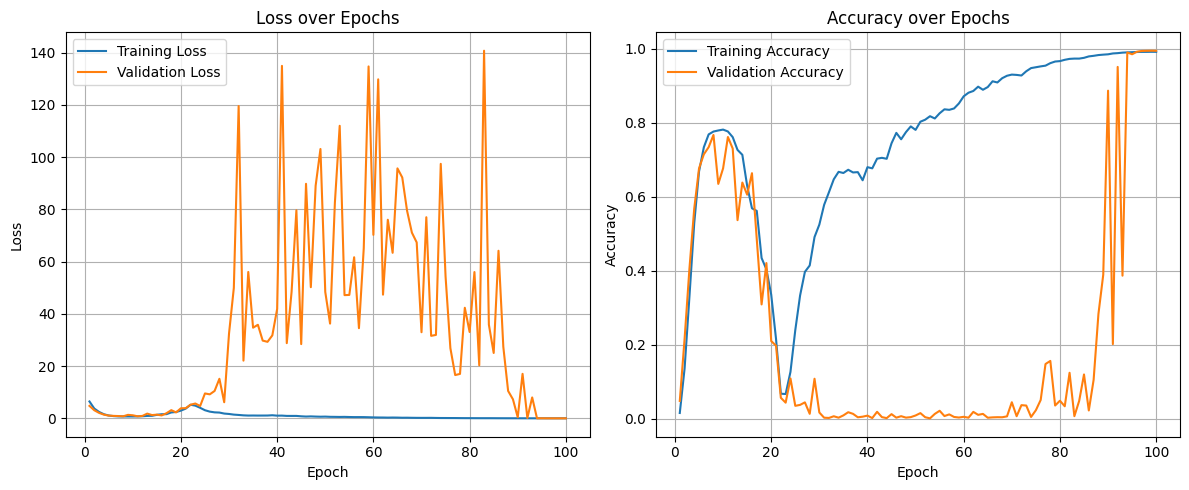

Plots generated successfully!


In [20]:
epochs_range = range(1, NUM_EPOCHS + 1) 
plt.figure(figsize=(12, 5)) # Tạo một hình vẽ mới với kích thước 12x5 inches
plt.subplot(1, 2, 1) # Tạo biểu đồ con thứ nhất (1 hàng, 2 cột)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # Tạo biểu đồ con thứ hai (1 hàng, 2 cột)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ con để tránh chồng chéo
plt.show() # Hiển thị các biểu đồ
print("Plots generated successfully!")